### Single Task Learner

In [1]:
from utils.utils import calculate_attributions
import matplotlib.pyplot as plt 
import numpy as np
root_dir = "G:/My Drive/master thesis/code/dl-4-tsc-mtl" 
classifier = 'fcn_mt'
archive_name = 'ucr'
dataset_name = 'GunPoint'

In [2]:
def get_len_and_step_size(attributions, slices=5):
    attr_len  = len(attributions)
    step_size = int(attr_len / slices)
    return attr_len,step_size

def highest_mean_attribution(att,slices): 
    attr_len, step_size = get_len_and_step_size(att,slices)
    candidates = []
    for x in range(0,attr_len,step_size):
        candidates.append(att[x:x+step_size-1].mean())
    return np.argmax(candidates), candidates

def find_lower_upper_bound(xvals,att,slices): 
    print(len(xvals))
    attr_len, step_size = get_len_and_step_size(att,slices)
    l1,l2,sl = (0,0,0)
    highest_mean, curr_mean = (0,0)
    boundaries = []
    for i,x in enumerate(range(0,attr_len,step_size)):
        lower_bound = xvals[x]
        upper_bound = xvals[x+step_size-1]
        boundaries.append((lower_bound,upper_bound))
        cur_mean = att[x:x+step_size-1].mean()
        #print(cur_mean)
        if cur_mean > highest_mean: 
            sl = i
            highest_mean = cur_mean 
            l1,l2 = (lower_bound, upper_bound)
    return l1,l2,sl,boundaries
#l1,l2,sl,boundaries = find_lower_upper_bound(attr_STL[ts][1],attr_STL[ts][3],5)

In [3]:
%matplotlib inline

def plot_attributions(ts,slices,attr_STL, attr_Unba_task_1,attr_Unba_task_2): 
    
    def plot_axv_lines(ax): 
        axes[ax].axvline(boundaries[0][0],color="black",alpha=0.3)
        for i in range(slices):
            #print(boundaries)
            axes[ax].axvline(boundaries[i][1],color="black",alpha=0.3)
    #ts = 30
    #slices = 5
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    #sp = plt.scatter(x=attr[ts][1], y=attr[ts][2], c=attr[ts][3], cmap='jet', marker='.', s=2, vmin=0, vmax=100, linewidths=0.0)
    # STL
    axes[0].scatter(x=attr_STL[ts][1], y=attr_STL[ts][2], c=attr_STL[ts][3], cmap='jet', marker='.', s=2, vmin=0, vmax=100, linewidths=2.0)
    l1,l2,sl,boundaries = find_lower_upper_bound(attr_STL[ts][1],attr_STL[ts][3],5)
    axes[0].axvspan(l1,l2,color="red",alpha=0.3)
    axes[0].set_title(f"STL: {sl}, pred: {attr_STL[ts][4]}, true: {attr_STL[ts][5]}")
    plot_axv_lines(0)
    # Unbalanced MTL 
    # Task 1
    axes[1].scatter(x=attr_Unba_task_1[ts][1], y=attr_Unba_task_1[ts][2], c=attr_Unba_task_1[ts][3], cmap='jet', marker='.', s=2, vmin=0, vmax=100, linewidths=2.0)
    l1,l2,sl,boundaries = find_lower_upper_bound(attr_Unba_task_1[ts][1],attr_Unba_task_1[ts][3],5)
    axes[1].axvspan(l1,l2,color="red",alpha=0.3)
    axes[1].set_title(f"MTL task1: {sl}, pred: {attr_Unba_task_1[ts][4]}, true: {attr_Unba_task_1[ts][5]}")
    plot_axv_lines(1)
    # Task 2
    axes[2].scatter(x=attr_Unba_task_2[ts][1], y=attr_Unba_task_2[ts][2], c=attr_Unba_task_2[ts][3], cmap='jet', marker='.', s=2, vmin=0, vmax=100, linewidths=2.0)
    l1,l2,sl,boundaries = find_lower_upper_bound(attr_Unba_task_2[ts][1],attr_Unba_task_2[ts][3],5)
    axes[2].axvspan(l1,l2,color="red",alpha=0.3)
    axes[2].axvspan(boundaries[attr_Unba_task_2[ts][4]][0],boundaries[attr_Unba_task_2[ts][4]][1],color="blue",alpha=0.3,label="ss")
    axes[2].set_title(f"MTL task2: {sl}, pred: {attr_Unba_task_2[ts][4]}, true: {attr_Unba_task_2[ts][5]}")
    plot_axv_lines(2)
    _, candidates = highest_mean_attribution(attr_Unba_task_2[ts][3],5)
    #print(candidates)
    #print(attr_Unba_task_2[ts][3][399:799])#/400)
    #print(attr_Unba_task_2[ts][3][799:1199])#/400)

    #fig.colorbar(sp)
    #fig.tight_layout()
    plt.show

In [11]:
root_dir = "G:/My Drive/master thesis/code/dl-4-tsc-mtl" 
prefix = 'STL'
dataset_name = 'GunPoint'
data_name = 'GunPoint'
attr_STL , _ = calculate_attributions(root_dir, archive_name, classifier, prefix, dataset_name, data_name, task=1)
prefix = 'Unbalanced'
dataset_name = 'GunPoint_Exp'
data_name = 'GunPoint_Exp'
attr_Unba_task_1, _ = calculate_attributions(root_dir, archive_name, classifier, prefix, dataset_name,data_name, task=1)
attr_Unba_task_2, _ = calculate_attributions(root_dir, archive_name, classifier, prefix, dataset_name,data_name, task=2)

IndexError: index 2 is out of bounds for axis 1 with size 2

50
2000
2000
2000
2000
2000
2000
2000
2000
2000


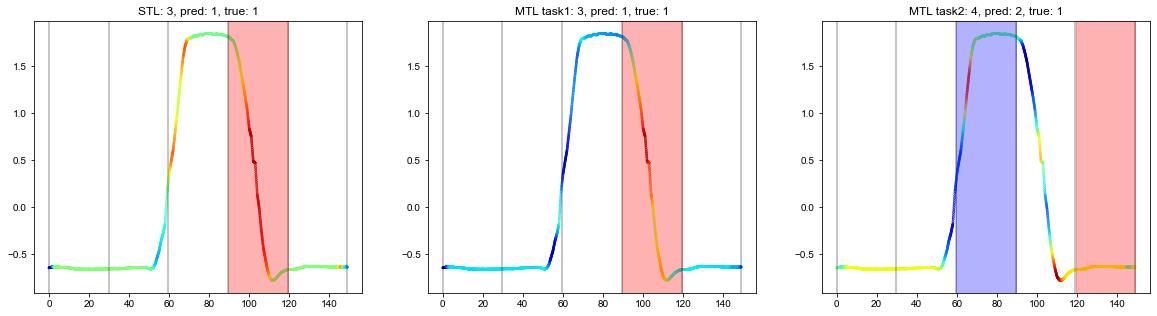

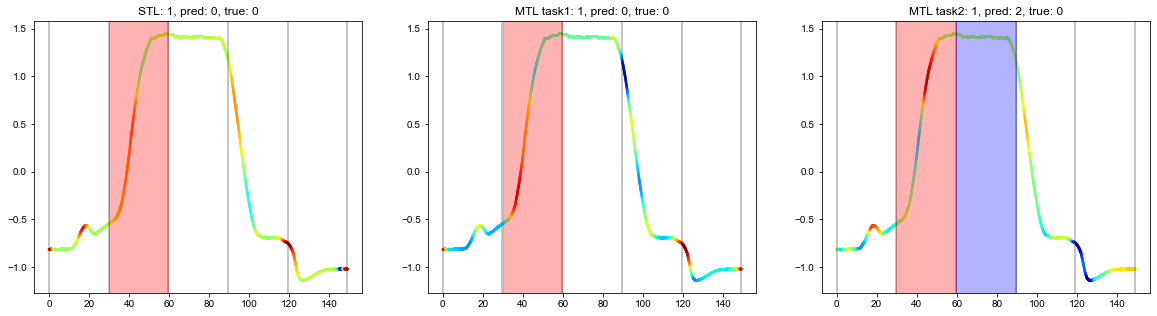

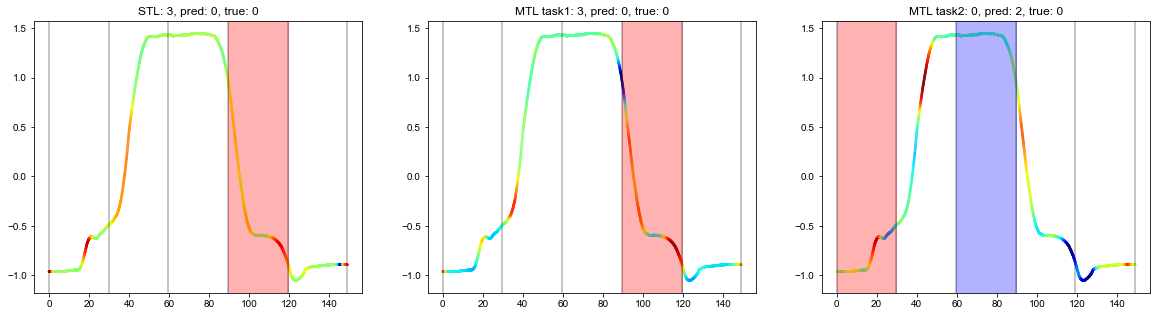

In [44]:
#Examples 
examples = [0,10,30]
print(len(attr_STL))
slices = 5
for ts in examples:
    plot_attributions(ts,slices,attr_STL, attr_Unba_task_1,attr_Unba_task_2)

In [365]:
root_dir = "G:/My Drive/master thesis/code/dl-4-tsc-mtl" 
attr_STL_test = calculate_attributions(root_dir, "STL", train_data=False)
attr_Unba_task_1_test = calculate_attributions(root_dir, "Unbalanced", train_data=False, task1=True)
attr_Unba_task_2_test = calculate_attributions(root_dir, "Unbalanced", train_data=False, task1=False)

G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TRAIN
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TEST
150
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TRAIN
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TEST
150
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint_Exp/GunPoint_Exp_TRAIN
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint_Exp/GunPoint_Exp_TEST
56


56


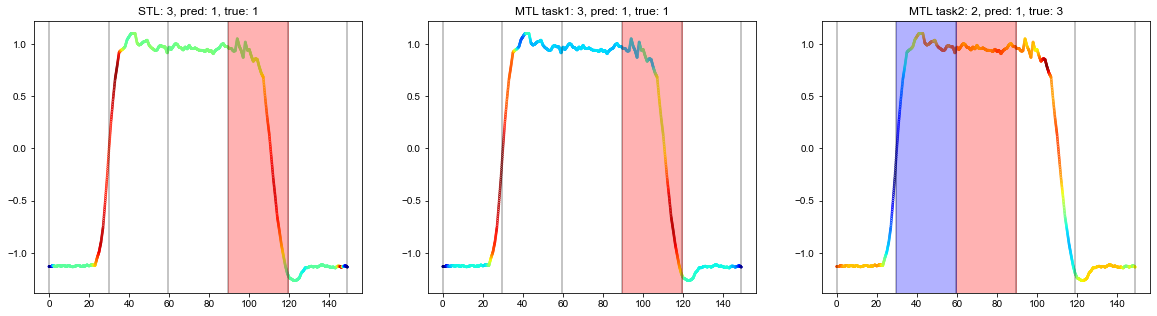

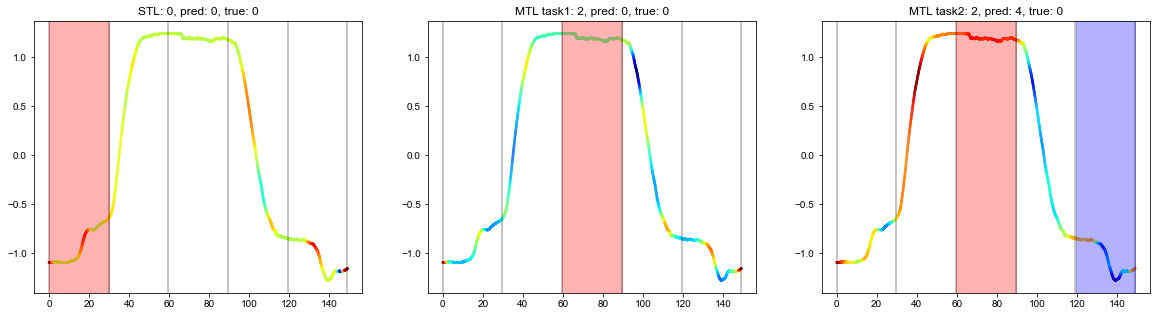

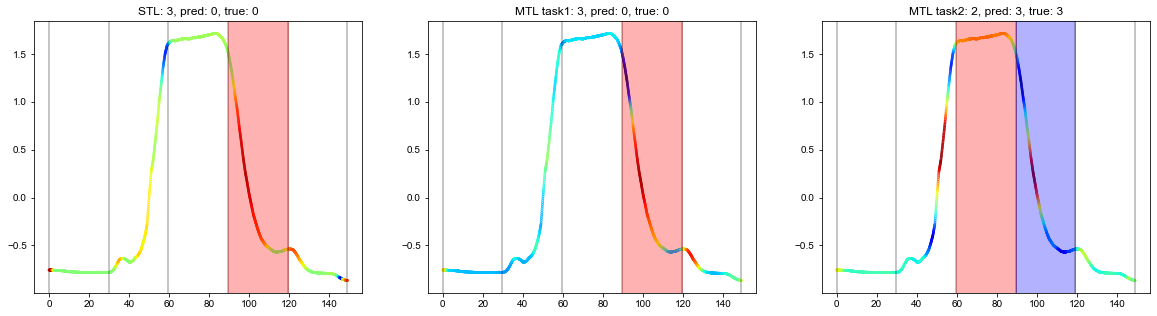

In [356]:
#Examples 
examples = [0,50,55]
print(len(attr_STL))
#ts = 30
slices = 5
for ts in examples:
    plot_attributions(ts,slices,attr_STL_test, attr_Unba_task_1_test,attr_Unba_task_2_test)